<a href="https://colab.research.google.com/github/khchu93/ComputerVision/blob/main/rcnn_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

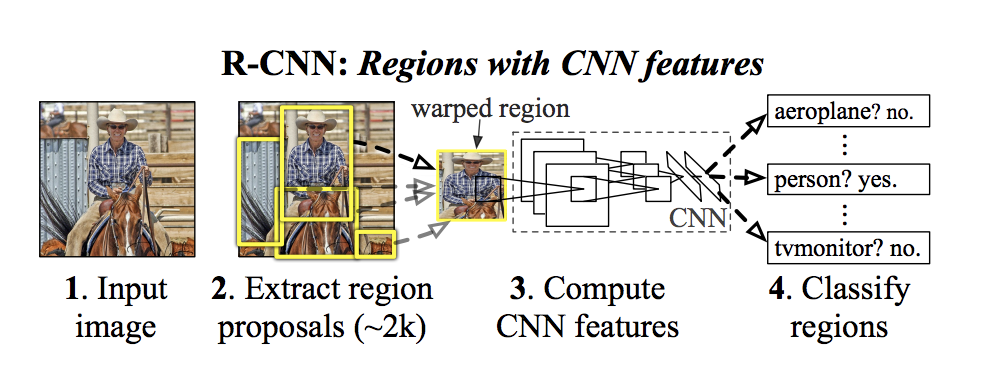

---

## R-CNN Implementation



**Step 0. Prepare dataset.**
- Unzip the Penn-Fudan dataset
- Extract bounding boxes from annotation folder

**Step 1. Extract region proposals**
- generate region proposals (~2000 regions per image) with selective search
- select the positive and negative region proposals (~50 regions per image) to proceed based on their IoU

**Step 2: Compute CNN features**
- Setup pretrained backbone model(VGG16)
- Fine-tune backbone model

**Step 3: Train SVM classifier and Bounding Box Regressor over extracted features from backbone model**
- extract features from the last fully-connected layer of VGG16
- Setup and train SVM classifier and bounding box regressor with extracted features from VGG16
- Apply NMS to remove overlapped bounding boxes with lower IoU score

**Step 4: Inference**

P.S. The following RCNN implementation is adapted from publicly available [online resources](https://medium.com/data-science/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0). I have added detailed annotations, explanations, and minor modifications to document my understanding of the underlying concepts.

## Step 0: Prepare dataset

The dataset that we use here is Penn-Fudan Database which contains: Images, Segmentation masks and Annotations. We only use Image and Annotation in this object detection project.

**Penn-Fudan Database for Pedestrian Detection and Segmentation**
- Purpose: pedestrian detection and segmentation
- Source: [Link](https://www.cis.upenn.edu/~jshi/ped_html/)
- Size
  - 170 images
  - 345 pedestrian instances
- Image properties
  - Format: PNG
  - Color: RGB
  - Resolution: varies between ~350×500 to 500×700 pixels
- Annotation
  - Format: Pascal VOC–style .txt files
  - Bounding boxes: (xmin, ymin, xmax, ymax) coordinates
  - Classes: pedestrian

We start from mounting our Google drive to the notebook, then unzip the dataset into the local folder and sample an image with annotation.

In [ ]:
! pip uninstall opencv-contrib-python opencv-python

Found existing installation: opencv-contrib-python 4.12.0.88
Uninstalling opencv-contrib-python-4.12.0.88:
  Would remove:
    /usr/local/lib/python3.12/dist-packages/cv2/*
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python-4.12.0.88.dist-info/*
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libQt5Core-e7f476e2.so.5.15.16
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libQt5Gui-3e966859.so.5.15.16
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libQt5Test-9ac3ed15.so.5.15.16
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libQt5Widgets-cd430389.so.5.15.16
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3cfa6167.so.5.15.16
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.12/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.12

In [ ]:
! pip install opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 MB 9.5 MB/s eta 0:00:00


In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os,cv2,keras, re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import zipfile

In [ ]:
def unzip_file(zip_file_path: str, extract_destination: str):
  """
  Unzip file, and return path to extracted file

  Args:
    zip_file_path (str): Path to zip file
    extract_destination (str): Path to extracted file folder
  Examples:
    unzip_file("/content/drive/My Drive/AI Dataset/Object Detection - Airplane/Images.zip", "/content/extracted_data")
  """
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_destination)
  filename = os.path.splitext(os.path.basename(zip_file_path))[0]

In [ ]:
def prepare_dataset():
  """
  Unzip dataset and return path to image, annotation and extracted folder

  Args:
    None
  Returns:
    extract_destination (str): Path to extracted file folder
    path (str): Path to image folder
    annot (str): Path to annotation folder
  Examples:
    extract_destination, path, annot = prepare_dataset()
  """
  print("="*80)
  print("Step 0: PREPARE DATASET")
  print("="*80)
  print("Starting dataset preparation ...\n")

  # unzip images and annotations.zip into colab
  extract_destination: str = '/content/extracted_data'
  unzip_file("/content/drive/My Drive/AI Dataset/Penn-Fudan Database/PennFudanPed.zip", extract_destination)
  path: str = os.path.join(extract_destination,'PennFudanPed/PNGImages')
  annot : str = os.path.join(extract_destination,'PennFudanPed/Annotation')

  # check the size of images and annotations
  files_Images = os.listdir(path)
  files_Annotations = os.listdir(annot)

  print(f"Total images: {len(files_Images)}")
  print(f"Total annotations: {len(files_Annotations)}")
  print("="*80)
  print("PREPARATION COMPLETED")
  print("="*80 + "\n")

  return extract_destination, path, annot


In [ ]:
def extract_bboxes_from_txt(file_path):
  """
  Extract bounding boxes from annotation

  Args:
    file_path (str): path to .txt annotation file
  Returns:
    boxes (list[int, int, int, int]): bounding boxes x1, y1, x2, y2
    labels (list[int]): bounding box's labels
  """
  boxes = []
  labels = []

  with open(file_path, "r") as f:
      for line in f:
          if "Bounding box for object" in line:
              # Regex to capture (xmin, ymin) - (xmax, ymax)
              match = re.search(r"\((\d+),\s*(\d+)\)\s*-\s*\((\d+),\s*(\d+)\)", line)
              if match:
                  xmin, ymin, xmax, ymax = map(int, match.groups())
                  boxes.append([xmin, ymin, xmax, ymax])
                  labels.append("pedestrian")  # fixed class for this dataset
  return boxes, labels

In [ ]:
def show_image_with_without_annotation(path: str, annot: str, filename: str):
  """
  Show target image with and without annotation from .csv file

  Args:
    path (str): Path to image folder
    annot (str): Path to annotation folder
    filename (str): Name of image
  Returns:
    None
  Examples:
    show_image(148)
  """
  print("Print sample image with/without annotation bounding boxes:")
  img = cv2.imread(os.path.join(path, (filename + ".png")))
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  boxes, _ = extract_bboxes_from_txt(os.path.join(annot, (filename + ".txt")))
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(img_rgb)
  plt.title(filename)
  for box in boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(img_rgb,(x1, y1),(x2, y2),(255, 0, 0), 2)
  plt.subplot(1, 2, 2)
  plt.imshow(img_rgb)
  plt.title(filename + " with bounding box")
  plt.show()

### Step 0: Prepare dataset - Main

Step 0: PREPARE DATASET
Starting dataset preparation ...

Total images: 170
Total annotations: 170
PREPARATION COMPLETED

Print sample image with/without annotation bounding boxes:


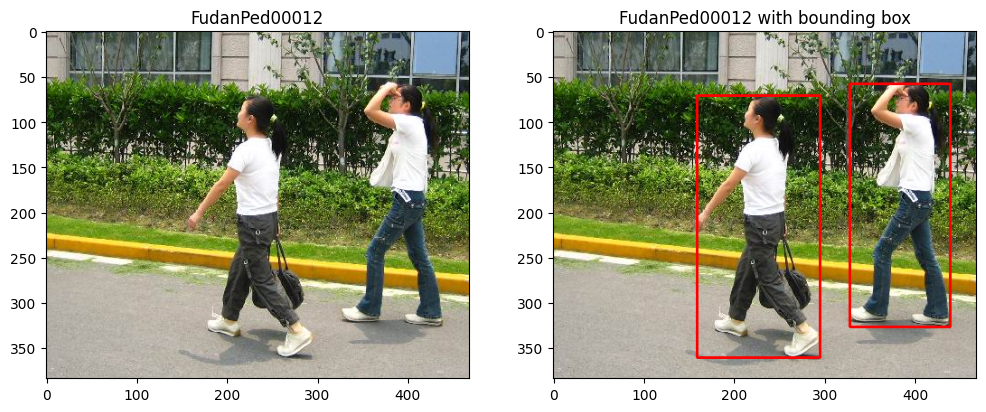

In [ ]:
# Step0: Dataset preparation
# unzip dataset
extract_destination, path, annot = prepare_dataset()

# Sample image to visualize image with ground truth bounding boxes
show_image_with_without_annotation(path, annot, filename = "FudanPed00012")

## Step 1: Extract region proposals

### Use selective search to generate proposals

Why selective search?
- In the earliest object detection methods, a **sliding window** approach was used. The algorithm would **scan every possible location on the image with windows of every possible size and aspect ratio**. This guaranteed that <u>all potential objects</u> were covered, but it came at an <u>enormous computational cost</u>.<br>
For a simple <u>224 × 224 image</u>, this could result in <u>over 600 million candidate bounding boxes</u>, which is completely impractical to process for just one image.

- To overcome this inefficiency, R-CNN introduced the idea of using an external region proposal algorithm, such as **Selective Search**.
Instead of exhaustively scanning the entire image, Selective Search intelligently **groups similar pixels and proposes around 2,000 high-quality candidate regions**, reducing the search space from hundreds of millions to just a <u>few thousand</u> — all <u>within one to two seconds</u>.

- This drastically improved efficiency while still maintaining good recall.

Setup the selective search

### Step 1: Extract region proposals - Main 1



Step 1: PROPOSE REGIONS
Created selective search

Print sample with first 200 selective search proposed regions:


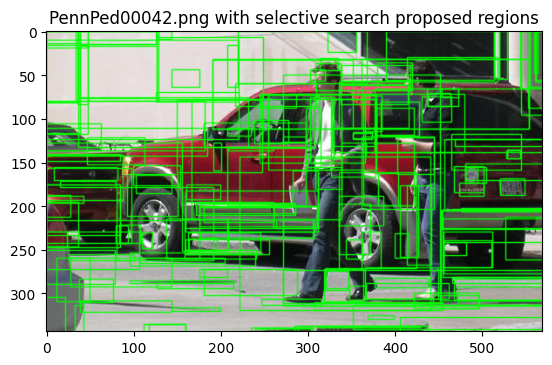

In [ ]:
# Step1: Region proposal

print("="*80)
print("Step 1: PROPOSE REGIONS")
print("="*80)

"""
Enable optimized code paths in OpenCV for better performance if it is not already enable
"""
cv2.setUseOptimized(True) # select the optimized settings for selective search
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()  # create selective search object
print("Created selective search\n")
"""
Sample an image with selective search with first 200 proposal regions
"""
filename = "PennPed00042.png"
im = cv2.imread(os.path.join(path, filename)) # select the image
img_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)   # convert to RGB
ss.setBaseImage(img_rgb)                        # set the image to process
ss.switchToSelectiveSearchFast()                # choose which proposal strategy to use: Fast(speed), Quality(accuracy)
rects = ss.process()                            # apply selective search on image
imOut = img_rgb.copy()
for i, rect in (enumerate(rects)):
  if i >200:                                    # show only 200 bounding boxes
    break
  x, y, w, h = rect
  cv2.rectangle(imOut, (x, y), (x + w, y + h), (0, 255, 0), 1, cv2.LINE_AA)
print("Print sample with first 200 selective search proposed regions:")
plt.title(filename + " with selective search proposed regions")
plt.imshow(imOut)
plt.show()


### Compare proposed regions with the ground truth bounding boxes using IoU


Generate the proposed regions for each image with the selective search object instantiated above. Once the region proposals are generated, we **still don’t know which of them actually contain objects**.<br>
To label them, we <u>compare each proposed box with ground-truth annotations</u> using **IoU** (Intersection over Union):

- High IoU → positive sample (foreground / object)
    - Label = 1, IoU > 0.5
- Low IoU → negative sample (background / non-object)
    - Label = 0, IoU < 0.3

During training, we need to **avoid class imbalance**, so we collect a <u>balanced set of positive and negative samples</u>.<br>
For <u>efficiency</u>, instead of checking all proposals, we only evaluate the <u>first ~2000 regions</u> and select up to <u>30 positive and 30 negative regions per image</u>.

We also measure the offset between proposed bounding box and ground truth bounding box to train the bounding box regression module that will be used later to adjust the bounding box location.

**Potential issues**
1. The code will often collect less than 30 samples per category due to the threshold constraints (IoU > 0.5 and IoU < 0.3).
2. There is no guarantee that the code will collect 30 samples per category for each image.
3. Since the code uses a global counter of 30 regions per image instead of per bounding box, it may collect samples from all ground truth boxes or disproportionately sample from just one, leaving other objects underrepresented.

In [ ]:
def get_iou(bb1: dict, bb2: dict):
  """
  Calculate the Intersection over Union (IoU) of two bounding boxes

  Args:
    bb1 (dict): bounding box 1
    bb2 (dict): bounding box 2
  Returns:
    float: IoU of two bounding boxes
  """
  # break the code if the bounding box's dimension is anormal
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
  x_left: int   = max(bb1['x1'], bb2['x1'])
  y_top: int    = max(bb1['y1'], bb2['y1'])
  x_right: int  = min(bb1['x2'], bb2['x2'])
  y_bottom: int = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
  if x_right < x_left or y_bottom < y_top:
      return 0.0
  # calculating intersection area.
  intersection_area: float = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
  bb1_area: int = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area: int = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
  iou: float = intersection_area / float(bb1_area + bb2_area - intersection_area)
  # break the code if iou out of range
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

In [ ]:
def get_target_bbox(gt: list, prop: list):
  """
  Measure the offset between proposed bounding box and ground truth bounding box

  Args:
    gt (list): ground truth bounding box
    prop (list): proposed bounding box
  Returns:
    list: target bounding box
  """
  x1, y1, x2, y2 = prop[0], prop[1], prop[2], prop[3]
  tx = (gt[0] - x1) / (x2 - x1)
  ty = (gt[1] - y1) / (y2 - y1)
  tw = np.log((gt[2] - gt[0]) / (x2 - x1))
  th = np.log((gt[3] - gt[1]) / (y2 - y1))
  bbox: list = [tx, ty, tw, th]
  return bbox

In [ ]:
from tqdm import tqdm

def process_image(path, annot, filename):
  """
  Collect up to 30 positive and 30 negative samples per image in the first 2000 proposed regions

  Args:
    filename (str): name of image
  Returns:
    local_train_image     (list): list of bounding box's content, extracted from image
    local_train_label     (list): list of bounding box's label (1 or 0)
    local_proposal_bbox   (list): list of proposed bounding boxe's size and location (x1, y1, x2, y2)
    local_gt_bbox         (list): list of ground truth bounding boxe's size and location (x1, y1, x2, y2)
    local_target_bbox     (list): list of target bounding boxe's translation and scale (tx, ty, tw, th), difference between ground truth and proposed bounding box
  """
  local_train_image   : list = []
  local_train_label   : list = []
  local_target_bbox   : list = []
  local_proposal_bbox : list = []
  local_gt_bbox       : list = []

  try:
    image_bgr = cv2.imread(os.path.join(path, filename))                        # select the image
    if image_bgr is None or image_bgr.shape[0] == 0 or image_bgr.shape[1] == 0: # skip corrupt/empty image
            print(f"Skipping corrupt or empty image: {filename}")
    annot_file = os.path.join(annot, filename.replace('.png', '.txt'))
    boxes, _ = extract_bboxes_from_txt(annot_file)

    # extract the bounding boxes from annotation
    gtBoxes: list = []
    for box in boxes:
      x1, y1, x2, y2 = box
      gtBoxes.append([x1, y1, x2, y2])

    # feed the image to selective search to generate proposal regions
    ss.setBaseImage(image_bgr)          # set given image as base image for selective search
    ss.switchToSelectiveSearchFast()    # select Fast porposal strategy (time is of the essence)
    ssresults = ss.process()            # apply selective search on image

    imout: np.ndarray = image_bgr.copy()
    posCounter: int = 0
    negCounter: int = 0
    flag      : bool = False
    posFlag   : bool = False
    negFlag   : bool = False

    # check the first 2000 regions and identify the first 30 positive and 30 negative samples
    for j, result in enumerate(ssresults):
      if j >= 2000 or flag:
        break
      x, y, w, h = result
      for gtBox in gtBoxes:
        # calculate the IoU between ground truth and proposal region
        bb1 = {"x1": gtBox[0],"x2": gtBox[2],"y1": gtBox[1],"y2": gtBox[3]}
        bb2 = {"x1": x,"x2": x + w,"y1": y,"y2": y + h}
        iou: float = get_iou(bb1, bb2)
        # resize the image to match VGG's input requirement
        timage = imout[y:y+h, x:x+w]

        if timage is None or timage.shape[0] == 0 or timage.shape[1] == 0:
          continue

        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)

        # capture the first 30 positive samples with Iou > 0.5, flag when has enough
        if iou > 0.50 and not posFlag:
          local_train_image.append(resized)
          local_train_label.append(1)
          local_proposal_bbox.append([x, y, x + w, y + h])
          local_gt_bbox.append(gtBox)
          target = get_target_bbox(gtBox, [x, y, x + w, y + h])
          local_target_bbox.append(target)
          posCounter += 1
          if posCounter > 35:
            posFlag = True

        # capture the first 30 negative samples with Iou < 0.3, flag when has enough
        if iou < 0.3 and not negFlag:
          local_train_image.append(resized)
          local_train_label.append(0)
          local_proposal_bbox.append([0,0,0,0])
          local_gt_bbox.append([0,0,0,0])
          local_target_bbox.append([0,0,0,0])
          negCounter += 1
          if negCounter > 15:
            negFlag = True

        # break and flag once enough samples are collected
        if posFlag and negFlag:
          flag = True
          break

  except Exception as e:
    print(f"Error in {filename} during step1 image process: {e}")

  return local_train_image, local_train_label, local_proposal_bbox, local_gt_bbox, local_target_bbox


In [ ]:
def generate_proposed_regions(extract_destination, path, annot):
  """
  Setup selective search, generarte region proposals for all images and store them into corresponding folders

  Args:
    extract_destination (str): Path to extracted file folder
    path (str): Path to image folder
    annot (str): Path to annotation folder
  Returns:
    train_image (np.array): Training images
    train_label (np.array): Training image's labels
    proposal_bbox (np.array): Proposal bounding boxes from selective search
    target_bbox (np.array): Offset between proposal and ground truth bounding boxes
    gt_bbox (bp.array): Ground truth bounding boxes
  Examples:
    train_image, train_label, proposal_bbox, target_bbox, gt_bbox = generate_proposed_regions(extract_destination, path, annot)
  """
  train_image = []
  train_label = []
  proposal_bbox = []
  target_bbox = []
  gt_bbox = []

  print("Generating region proposals ...\n")

  # generate proposal regions through selective search for each image
  for filename in tqdm(os.listdir(path)):
    local_train_image, local_train_label, local_proposal_bbox, local_gt_bbox, local_target_bbox = process_image(path, annot, filename)
    train_image.extend(local_train_image)
    train_label.extend(local_train_label)
    proposal_bbox.extend(local_proposal_bbox)
    target_bbox.extend(local_target_bbox)
    gt_bbox.extend(local_gt_bbox)
  print("\nRegion proposals generated.\n")
  train_image= np.array(train_image)
  train_label= np.array(train_label)
  proposal_box=np.array(proposal_bbox)
  target_box=np.array(target_bbox)
  gt_box=np.array(gt_bbox)
  print("Save generated data.\n")
  # save train image, label to extracted_data folder
  out_dir = os.path.join(extract_destination,'R-CNN/data')
  os.makedirs(out_dir, exist_ok=True)
  np.save(os.path.join(out_dir,'train_image.npy'), train_image)
  np.save(os.path.join(out_dir,'train_label.npy'), train_label)
  np.save(os.path.join(out_dir,'proposal_box.npy'), proposal_bbox)
  np.save(os.path.join(out_dir,'target_box.npy'), target_bbox)
  np.save(os.path.join(out_dir,'gt_box.npy'), gt_bbox)
  print("Data saved.\n")
  print(f"Nb of extracted bounding box from image: {len(train_image)}")
  classes, counts = np.unique(train_label, return_counts=True)
  print(f"Nb of unique class labels: {len(classes)}")
  print(f"Nb of extracted bounding box for each class: {counts}\n")

  print("="*80)
  print("REGIONS PROPOSED")
  print("="*80)

  return train_image, train_label, proposal_bbox, target_bbox, gt_bbox

### Step 1: Extract region proposals - Main 2

In [ ]:
# Step1: Region proposal
# Enable optimized code paths in OpenCV for better performance and create selective search object
train_image, train_label, proposal_bbox, target_bbox, gt_bbox = generate_proposed_regions(extract_destination, path, annot)

Generating region proposals ...



100%|██████████| 170/170 [06:32<00:00,  2.31s/it]



Region proposals generated.

Save generated data.

Data saved.

Nb of extracted bounding box from image: 5795
Nb of unique class labels: 2
Nb of extracted bounding box for each class: [2720 3075]

REGIONS PROPOSED


## Step 2: Compute CNN features

Now that the proposed regions are ready, we can set up the ConvNet model.

We use **VGG16** as our architecture, consistent with the original R-CNN paper. We load VGG16 **pretrained on ImageNet** to leverage learned features rather than training from scratch. Our training strategy <u>freezes all convolutional layers (feature extractor) and trains only the two fully connected layers (classifier)</u>.


The <u>output layer</u> is modified from <u>1000 classes to 1 classes</u> for our binary classification task with **sigmoid** instead of softmax, cause there is only one class in our project.  The model is compiled with **binary cross-entropy loss** and **accuracy** as the evaluation metric. Finally, the model is fine-tuned on our airplane dataset using the **Adam optimizer** and trained for 4 epochs.

In [ ]:
from keras import Model

### Setup pretrained backbone model (VGG16) and fine-tune it

In [ ]:
def load_data(extract_destination):
  """
  Load generated bounding box's image, label from extracted_data folder

  Args:
    extract_destination (str): Path to extracted file folder
  Returns:
    train_image (list): list of bounding box's content, extracted from image
    train_label (list): list of bounding box's label (1 or 0)
    proposal_bbox (list): list of proposed bounding boxe's size and location (x1, y1, x2, y2)
    target_bbox (list): list of target bounding boxe's translation and scale (tx, ty, tw, th), difference between ground truth and proposed bounding box
    gt_bbox (list): list of ground truth bounding boxe's size and location
  Examples:
    train_image, train_label, proposal_bbox, target_bbox, gt_bbox = load_data(extract_destination)
  """
  train_image  = np.load(os.path.join(extract_destination,'R-CNN/data/train_image.npy'))
  train_label  = np.load(os.path.join(extract_destination,'R-CNN/data/train_label.npy'))
  target_box   = np.load(os.path.join(extract_destination,'R-CNN/data/target_box.npy'))
  gt_box       = np.load(os.path.join(extract_destination,'R-CNN/data/gt_box.npy'))
  proposal_box = np.load(os.path.join(extract_destination,'R-CNN/data/proposal_box.npy'))
  train_image  = np.array([cv2.resize(img, (224, 224)) for img in train_image])

  return train_image, train_label, proposal_box, target_box, gt_box


In [ ]:
def train_vgg16(extract_destination, train_image, train_label):
  """
  instantiate and customize the VGG16 model with pretrained weights and the fully connected layers
  Args:
    extract_destination (str): Path to extracted file folder
  Returns:
    model (keras.Model): VGG16 model
  Examples:
    model = train_vgg16(extract_destination)
  """
  print("="*80)
  print("Step 2: SETUP VGG16 AND FINE-TUNING")
  print("="*80)

  print("Setup vgg16 ...\n")
  # vggmodel = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
  vggmodel = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

  # freeze all except fully connected layers
  for layers in (vggmodel.layers)[:-2]:
      layers.trainable = False

  # replace the prediction layer of pretrained VGG16 with custom layer (activation = sigmoid, output = 1)
  x = vggmodel.get_layer('fc2')
  last_layer = x.output
  predictions = tf.keras.layers.Dense(1, activation='sigmoid')(last_layer)

  # setup the VGG loss, optimizer and metrics
  model = tf.keras.Model(inputs = vggmodel.input, outputs = predictions)
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

  # show model summary
  model.summary()
  print("\nVGG16 setup.\n")

  print("Fine tune vgg16 ...\n")
  model.fit(train_image, train_label, epochs = 4, batch_size = 4, verbose = 1, validation_split = 0.2, shuffle = True)
  model.save(os.path.join(extract_destination,'vgg16_model.keras'))
  print("Model fine-tuned.\n")

  print("="*80)
  print("VGG16 READY")
  print("="*80)
  return model


###Step 2: Compute CNN features - Main

In [ ]:
# Step2: VGG16 setup & fine tune

# # Load generated data (optional)
# train_image, train_label, proposal_bbox, target_bbox, gt_bbox = load_data(extract_destination)

vgg16 = train_vgg16(extract_destination, train_image, train_label)

Step 2: SETUP VGG16 AND FINE-TUNING
Setup vgg16 ...

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 16,785,409 (64.03 MB)

 Non-trainable params: 117,479,232 (448.15 MB)


VGG16 setup.

Fine tune vgg16 ...

Epoch 1/4
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step - acc: 0.9352 - loss: 2.4744 - val_acc: 0.9327 - val_loss: 0.3467
Epoch 2/4
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - acc: 0.9754 - loss: 0.1475 - val_acc: 0.9465 - val_loss: 0.2227
Epoch 3/4
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 43s 37ms/step - acc: 0.9764 - loss: 0.2245 - val_acc: 0.9664 - val_loss: 0.4124
Epoch 4/4
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - acc: 0.9833 - loss: 0.1041 - val_acc: 0.9698 - val_loss: 0.5139
Model fine-tuned.

VGG16 READY


## Step 3: Train SVM classifier and Bounding Box Regressor over extracted features from backbone

A **SVM classifier** is used to <u>replace the fine-tunned VGG16's final softmax layer</u> in RCNN because it achieved significantly **better object detection performance**. <br>
- The author states that the mAP on the PASCAL VOC 2007 dataset dropped from 54.2% (with SVMs) to 50.9% (with softmax) when using the softmax layer directly.

To do so, we first extract the features from VGG16 at the output of its last(/second) fully-connected layer. Then, use this extracted features as input to train both the SVM classifier and Bounding box regressor.

NMS is applied at the end to remove overlapped bounding boxes with lower confidence score.

### Extract features from VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from pathlib import Path

def extract_features(extract_destination, train_image, model):
  """
  Extract features from VGG16 fc2 output
  Args:
    extract_destination (str): Path to extracted file folder
    train_image (list): list of bounding box's content, extracted from image
    model (keras.Model): VGG16 model
  Returns:
    fc2_feature (list): list of fc2 output
  Examples:
    fc2_feature = extract_features(extract_destination, train_image)
  """
  print("="*80)
  print("Step 3: TRAIN SVM CLASSIFIER AND BOUNDING BOX REGRESSOR")
  print("="*80)

  train_image = np.array([cv2.resize(img, (224, 224)) if img.shape[-1]==3
                          else cv2.cvtColor(cv2.resize(img, (224, 224)), cv2.COLOR_GRAY2RGB)
                          for img in train_image])

  # Preprocess image to match VGG16 requirements: RGB -> BGR, mean center, 0 to 255 pixel values
  train_img_preprocess = preprocess_input(train_image.astype('float32'))
  print(f"Prepocessed training image set shape (nb of regions, nb of pixel in height, nb of pixel in weight, nb of channel): {train_img_preprocess.shape}/n")

  print("Extracting features ...\n")
  # Extract the fine-tuned VGG16 model without the final layer
  fc2_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('fc2').output)

  # verify the fc2 output shape: 62 regions, 4096 features
  fc2_feature = fc2_model.predict(train_img_preprocess, batch_size=64, verbose=1)
  print(f"fc2 output shape (nb of region proposal, nb of features): {fc2_feature.shape}\n")

  # save the extracted model (VGG16 without final layer)
  fc2_model.save(os.path.join(extract_destination,'fc2_model.keras'))
  np.save(os.path.join(extract_destination, 'fc2_features.npy'), fc2_feature)

  print("FEATURES EXTRACTED.")

  return fc2_model, fc2_feature

###Step 3: Train SVM classifier and Bounding box regressor - Main 1

In [ ]:
# Step3: Feature extraction
fc2_model, fc2_feature = extract_features(extract_destination, train_image, vgg16)

Step 3: TRAIN SVM CLASSIFIER AND BOUNDING BOX REGRESSOR
Prepocessed training image set shape (nb of regions, nb of pixel in height, nb of pixel in weight, nb of channel): (5795, 224, 224, 3)/n
Extracting features ...

91/91 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step
fc2 output shape (nb of region proposal, nb of features): (5795, 4096)

FEATURES EXTRACTED.


###Setup mAP metric to validate the model

We use the **mAP** metric to validate the model since it fairly measures detection performance across classes, confidence scores and localization.

<u>Pros</u>: holistic evaluation (classification + localization quality), class balance (average out), threshold-free for scores (whole PR curve) <br>
<u>Cons</u>: complex to interpret, IoU sensitivity (one IoU threshold per curve, but it can be averaged out), over-penalization for near-misses (near miss score is the same as score 0)

Recipe:
1. Fix an **IoU threshold** (e.g., 0.5).
2. Sweep **confidence thresholds** to build a PR curve.
3. Compute AP (area under PR curve) per class (Fig.1).
4. Average across classes (and IoUs if COCO-style) → mAP.<br>

<p float="left">
  <figure style="display:inline-block; margin: 10px; text-align:center;">
    <img src="https://learnopencv.com/wp-content/uploads/2022/08/mean-average-precision-map-final-precision-interpolated-graph.png" width="90%" />
    <figcaption>Fig.1 AP with interpolation method example = 1/11 * Sum(11 point interpolated precision) = 0.349 = 34.9%</figcaption>
  </figure>
</p>

In [ ]:
from sklearn.metrics import average_precision_score

def evaluate_mAP(y_true_cls, y_pred_cls, y_true_box, y_pred_box):
  """
  Calculate the mAP (mean average precision) score

  Args:
    y_true_cls (list): list of ground truth class labels
    y_pred_cls (list): list of predicted
    y_true_box (list): list of ground truth bounding boxe's size and location (x1, y1, x2, y2)
    y_pred_box (list): list of predicted bounding boxe's size and location
  Returns:
    float: mAP score
  """
  cls_ap = average_precision_score(y_true_cls, y_pred_cls)
  def iou(boxA, boxB):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes

    Args:
      boxA (list): bounding box 1
      boxB (list): bounding box 2
    Returns:
      float: IoU of two bounding boxes
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    return interArea / float(boxAArea + boxBArea - interArea)

  iou_scores = [iou(p, t) for p, t in zip(y_pred_box, y_true_box)]
  mean_iou = np.mean(iou_scores)
  return cls_ap, mean_iou

###Apply NMS to remove duplicate/overlapping boxes

NMS (Non-Maximum Suppresion) removes redundant overlapping boxes while keeping only the most confident one.

Pros: Remove redundant boxes, flexible via IoU threshold <br>
Cons: Hard threshold may remove correct boxes
Variants: Soft-NMS, Class-aware NMS, Learned NMS

Recipe:
1. Input: <br>
&nbsp;- List of predicted boxes: boxes = [x1, y1, x2, y2]<br>
&nbsp;- Confidence scores for each box: scores = [s1, s2, ...]<br>
&nbsp;- IoU threshold (e.g., 0.5)
2. Sort boxes by confidence score (descending order).
3. Iteratively select boxes:<br>
&nbsp;a. Pick the box B with the highest score, add it to the final list.<br>
&nbsp;b. Remove all other boxes that have IoU > threshold with B (they are redundant).<br>
&nbsp;c. Repeat with the remaining boxes.
4. Output:<br>
&nbsp;- List of selected boxes (one per object).

In [ ]:
def NMS(boxes, scores, overlap_thresh=0.3):
  """
  Remove redundant overlapping boxes while keeping only the most confident one

  Args:
    boxes (list): list of predicted boxes
    scores (list): list of confidence scores for each box
    overlap_thresh (float): IoU threshold
  Returns:
    list: list of selected boxes
  """
  if len(boxes) == 0:
      return []

  boxes = boxes.astype("float")
  pick = []
  x1, y1, x2, y2 = boxes.T
  area = (x2 - x1 + 1) * (y2 - y1 + 1)
  idxs = np.argsort(scores)

  while len(idxs) > 0:
    last = idxs[-1]
    pick.append(last)
    xx1 = np.maximum(x1[last], x1[idxs[:-1]])
    yy1 = np.maximum(y1[last], y1[idxs[:-1]])
    xx2 = np.minimum(x2[last], x2[idxs[:-1]])
    yy2 = np.minimum(y2[last], y2[idxs[:-1]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (area[last] + area[idxs[:-1]] - inter)

    idxs = idxs[np.where(ovr <= overlap_thresh)]

  return pick

###Train SVM classifier and Bounding box regressor

In [ ]:
from sklearn.svm import SVC, SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from pathlib import Path
import os
import joblib

def train_svm_and_regressor(extract_destination, X, y_class, y_bbox):
  """
  Train SVM classifier and SVR regressor

  Args:
    extract_destination (str): Path to extracted file folder
    X (list): list of fc2 output
    y_class (list): list of ground truth class labels
    y_bbox (list): list of ground truth bounding boxe's size and location
  Returns:
    clf (sklearn.svm.SVC): SVM classifier
    reg (sklearn.svm.SVR): SVR regressor
  Examples:
    train_svm_and_regressor(extract_destination)
  """
  # set data to np.array
  X = np.array(X)
  y_class = np.array(y_class)
  y_bbox = np.array(y_bbox)

  print("Split dataset to training and validation with ratio of 8:2\n")
  # Train-test split (ratio: 8:2)
  X_train, X_test, y_train_cls, y_test_cls, y_train_box, y_test_box = train_test_split(
      X, y_class, y_bbox, test_size=0.2, random_state=42
  )

  print("Train SVM classifier ...")
  # train class specific linear SVMs
  clf = SVC(kernel='linear', probability=True)
  clf.fit(X_train, y_train_cls)
  print("SVM classifier trained.\n")

  print("Train bounding box regressor ...")
  # bounding box regression
  reg = MultiOutputRegressor(SVR())
  reg.fit(X_train[y_train_cls == 1], y_train_box[y_train_cls == 1])  # only for object class
  print("Bounding box regressor trained.\n")

  # Save classifier
  joblib.dump(clf, os.path.join(extract_destination, 'svm_classifier.pkl'))

  # Save regressor
  joblib.dump(reg, os.path.join(extract_destination, 'svr_regressor.pkl'))

  # testing
  y_pred_class  = clf.predict(X_test)
  print(f"Y test class: {y_test_cls[:5]}")
  print(f"Y pred class: {y_pred_class[:5]}")
  y_pred_box = reg.predict(X_test[y_test_cls == 1])
  cls_ac , mean_ac = evaluate_mAP(y_test_cls, y_pred_class, y_test_box, y_pred_box)
  print(f"Class accuracy : {cls_ac}")
  print(f"Boundary box accuracy: {mean_ac}")

  print("="*80)
  print("R-CNN TRAINING COMPLETED.")
  print("="*80)

  return clf, reg

###Step 3: Train SVM classifier and Bounding box regressor - Main 2

In [ ]:
# Step4: SVM & regressor training
clf, reg = train_svm_and_regressor(extract_destination, fc2_feature, train_label, target_bbox)

Split dataset to training and validation with ratio of 8:2

Train SVM classifier ...
SVM classifier trained.

Train bounding box regressor ...
Bounding box regressor trained.

Y test class: [1 0 1 0 1]
Y pred class: [1 0 1 0 1]
Class accuracy : 0.962379200503078
Boundary box accuracy: 0.537015012935188
R-CNN TRAINING COMPLETED.


##Step 4: Inference

In [ ]:
def apply_deltas(prop, deltas):
  """
  Apply the predicted adjustments(delta) to proposed bounding box
  Args:
    prop (list): list of proposed bounding boxe's size and location (x1, y1, x2, y2)
    deltas (list): list of target bounding boxe's translation and scale (tx, ty, tw, th)
  Returns:
    list (list): list of predicted bounding boxe's size and location (x1, y1, x2, y2)
  Examples:
    x1, y1, x2, y2 = apply_deltas(region, bbox)
  """
  x1, y1, x2, y2 = prop
  prop_w = x2 - x1
  prop_h = y2 - y1

  tx, ty, tw, th = deltas
  pred_x1 = x1 + tx * prop_w
  pred_y1 = y1 + ty * prop_h
  pred_x2 = pred_x1 + np.exp(tw) * prop_w
  pred_y2 = pred_y1 + np.exp(th) * prop_h

  return [int(pred_x1), int(pred_y1), int(pred_x2), int(pred_y2)]

In [ ]:
def inference_with_nms(image, region_proposals, clf, reg, fc2_model, iou_thresh=0.3):
  """
  Predict label and bounding box location of each proposed regions in image
  """
  pred_boxes = []
  scores = []
  # predict label and location of each proposed regions
  for region in region_proposals:
    x1, y1, x2, y2 = region
    roi = image[y1:y2, x1:x2]
    if roi.shape[0] < 10 or roi.shape[1] < 10:
      continue
    roi_resized = cv2.resize(roi, (224, 224))
    roi_rgb = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
    roi_pre = preprocess_input(roi_rgb.astype('float32'))
    # extract feature output of VGG16 of image
    feature = fc2_model.predict(np.expand_dims(roi_pre, axis=0), verbose=0)
    # predict label from feature
    is_object = clf.predict(feature)[0]
    # predict bounding box location from feature + adjust location with delta
    if is_object:
      score = clf.predict_proba(feature)[0][1]
      bbox = reg.predict(feature)[0]
      pred_box = apply_deltas(region,bbox)
      pred_boxes.append(pred_box)
      scores.append(score)

  # if there is object detected in image, print result
  if pred_boxes:
    idxs = NMS(np.array(pred_boxes), np.array(scores), overlap_thresh=iou_thresh)
    final_boxes = [pred_boxes[i] for i in idxs]
    final_scores = [scores[i] for i in idxs]
    print('prediction_box:',final_boxes)
    return final_boxes, final_scores
  return [], []

In [ ]:
def visualize(image, pred_boxes=None, true_boxes=None, label='object', scores=None):
  image = image.copy()

  # Draw ground truth boxes (can be one or many)
  if true_boxes is not None:
    if isinstance(true_boxes[0], list) or isinstance(true_boxes[0], tuple):
      for box in true_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # blue for GT
    else:
      x1, y1, x2, y2 = map(int, true_boxes)
      cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
  # Draw predicted boxes (can be one or many)
  if pred_boxes is not None:
    if isinstance(pred_boxes[0], list) or isinstance(pred_boxes[0], tuple):
      for i, box in enumerate(pred_boxes):
        x1, y1, x2, y2 = map(int, box)
        score = scores[i] if scores and i < len(scores) else None
        text = f'{label}: {score:.2f}' if score is not None else label
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # green for prediction
        cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
      x1, y1, x2, y2 = map(int, pred_boxes)
      score = scores[0] if scores else None
      text = f'{label}: {score:.2f}' if score is not None else label
      cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
      cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
  # Show the image
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

###Step 4: Inference - Main

prediction_box: [[131, 95, 197, 301], [387, 84, 542, 346]]


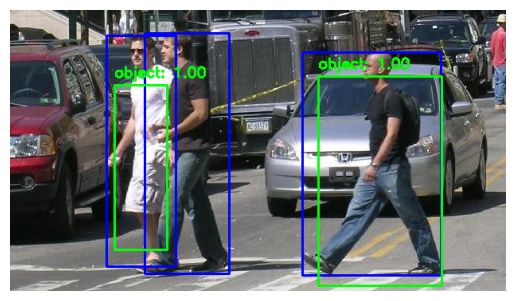

In [ ]:
filename ="PennPed00035.png"
image = cv2.imread(os.path.join(path, filename))
train_image, train_label, region_proposal, gt_bbox, target_bbox = process_image(path, annot, filename)
final_boxes, final_scores = inference_with_nms(image, region_proposal, clf, reg, fc2_model)
visualize(image, final_boxes, gt_bbox, label='object', scores=final_scores)

## Reference


[RCNN implimentation](https://github.com/Hulkido/RCNN/tree/master) <br>
[Step-by-Step R-CNN Implementation From Scratch In Python](https://medium.com/data-science/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55) <br>
[Understanding R-CNN Through Implementation from Scratch](https://medium.com/@srikantnayak.2010/understanding-r-cnn-through-implementation-from-scratch-fd729be36553)<br>
[R-CNN: Clearly EXPLAINED!](https://www.youtube.com/watch?v=nJzQDpppFj0)